# `StableSpectralElements.jl` - 2D Euler example using entropy-stable  discretization

First, let's load the packages used in this example.

In [148]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, TimerOutputs, StaticArrays, BenchmarkTools

We will be solving the two-dimensional compressible Euler equations, which are a hyperbolic system of conservation laws given by
$$
\begin{aligned}
\partial_t \rho(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t)) &= 0,\\
\partial_t ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t)) + \nabla_{\boldsymbol{x}} \cdot ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t) \otimes \boldsymbol{V}(\boldsymbol{x},t) + P(\boldsymbol{x},t)\boldsymbol{I}) &= \boldsymbol{0},\\
\partial_t E(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot ((E(\boldsymbol{x},t) + P(\boldsymbol{x},t))\boldsymbol{V}(\boldsymbol{x},t)) &= 0,
\end{aligned}
$$
with 
$$
 P(\boldsymbol{x},t) = (\gamma - 1)\big(E(\boldsymbol{x},t) - \tfrac{1}{2} \rho(\boldsymbol{x},t) \lVert \boldsymbol{V}(\boldsymbol{x},t) \rVert^2 \big),
$$
where $\gamma = 1.4$ is the specific heat ratio. The initial condition is an isentropic vortex in a uniform flow on the domain $\Omega = (0,1)^2$ with periodic boundary conditions, at a  Mach number of 0.4. The density field is shown below.

![620x400](figures/euler_initial_condition.png)

In [149]:
mach_number = 0.4
angle = π/3
L = 1.0
γ=1.4
T = L/mach_number # end time
strength = sqrt(2/(γ-1)*(1-0.75^(γ-1))) # for central value of ρ=0.75

conservation_law = EulerEquations{2}(γ)
exact_solution = IsentropicVortex(conservation_law, θ=angle,
    Ma=mach_number, β=0.0, R=1.0/10.0, x_0=(L/2,L/2));

Let's discretize the above problem using a `ModalMulti` discretization of degree $p = 3$ on an isoparametrically warped triangular mesh with $M = 4$ edges in each direction. We will use an entropy-stable flux-differencing scheme employing [Ranocha's two-point flux](https://link.springer.com/chapter/10.1007/978-3-030-39647-3_42) and Lax-Friedrichs interface dissipation; to obtain an entropy-conservative scheme, one can instead take `inviscid_numerical_flux=EntropyConservativeNumericalFlux()`. The modal (i.e. non-collocated) formulation necessitates the introduction of an "entropy projection" procedure as well as a facet correction equivalent to the use of hybridized/decoupled SBP operators as proposed by [Chan (2018)](https://arxiv.org/abs/1708.01243).

In [169]:
p = 4
M = 4

form = FluxDifferencingForm(inviscid_numerical_flux=LaxFriedrichsNumericalFlux())

reference_approximation = ReferenceApproximation(ModalTensor(p), Tri(), mapping_degree=p)

uniform_mesh = uniform_periodic_mesh(reference_approximation, ((0.0,L),(0.0,L)), (M,M))

mesh = warp_mesh(uniform_mesh, reference_approximation, ChanWarping(1.0/16, (L,L)))

spatial_discretization = SpatialDiscretization(mesh, reference_approximation)

results_path = save_project(conservation_law,
    spatial_discretization, exact_solution, form, (0.0, T),
    "results/euler_vortex_2d/", overwrite=true, clear=true);

ode = semidiscretize(conservation_law, spatial_discretization, 
    exact_solution, form, (0.0, T), parallelism=Serial());

We'll now plot the mesh, showing the volume and facet quadrature nodes.

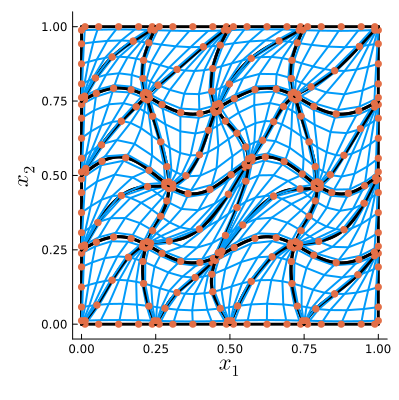

In [170]:
plot(spatial_discretization, grid_connect=true, fmt=:png)

The resulting system of ordinary differential equations can then be solved as usual using OrdinaryDiffEq.jl's `solve` function.

In [171]:
N_t = 25*M*(p+1)
reset_timer!()
sol = solve(ode, DP8(), adaptive=false, dt=T/N_t, save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), 5))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            40.4s /  17.2%           3.59GiB /  82.3%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 semi-disc. residual    8.20k    6.95s  100.0%   847μs   2.96GiB  100.0%   378KiB
   time deriv.           262k    3.42s   49.2%  13.0μs   1.35GiB   45.5%  5.38KiB
   nodal values          262k    2.94s   42.4%  11.2μs   1.61GiB   54.5%  6.44KiB
 ────────────────────────────────────────────────────────────────────────────────


The $L^2$ error in each conservative variable (i.e. $\rho$, $\rho V_1$, $\rho V_2$, and $E$) can be computed as follows.

In [172]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T))

L2 error:
[1.982043017142168e-14, 5.332689591444167e-14, 7.635718844096754e-14, 4.755526624443788e-14]


We'll check that the scheme is indeed conservative by plotting the evolution of the integrated conservative variables.

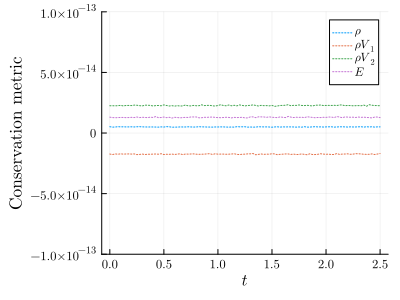

In [168]:
conservation = analyze(PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization),
    load_time_steps(results_path), normalize=false)

conservation_plot = plot(conservation, ylabel="Conservation metric", 1, 
    net_change=false, label="\$\\rho\$", size=(400,300), fmt=:png, ylims=[-1e-13,1e-13])
plot!(conservation_plot, conservation, label="\$\\rho V_1\$", 2, net_change=false)
plot!(conservation_plot, conservation, label="\$\\rho V_2\$", 3, net_change=false)
plot!(conservation_plot, conservation, label="\$E\$", 4, net_change=false)

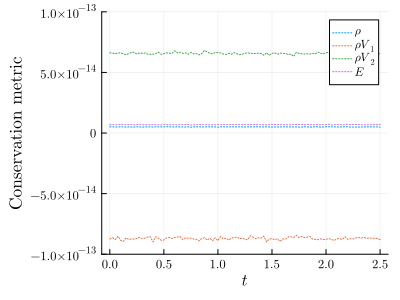

In [174]:
conservation = analyze(PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization),
    load_time_steps(results_path), normalize=true)

conservation_plot = plot(conservation, ylabel="Conservation metric", 1, 
    net_change=false, label="\$\\rho\$", size=(400,300), fmt=:png, ylims=[-1e-13,1e-13])
plot!(conservation_plot, conservation, label="\$\\rho V_1\$", 2, net_change=false)
plot!(conservation_plot, conservation, label="\$\\rho V_2\$", 3, net_change=false)
plot!(conservation_plot, conservation, label="\$E\$", 4, net_change=false)

We can finally plot the evolution of the integrated mathematical entropy $\int_{\Omega} S(U(\boldsymbol{x},t)) \, \mathrm{d} \boldsymbol{x}$, where $S(U(\boldsymbol{x},t)) = - \tfrac{1}{1-\gamma}\rho(\boldsymbol{x},t) \ln(p(\boldsymbol{x},t)/\rho(\boldsymbol{x},t)^\gamma) $, again using the scheme's collocated LGL quadrature rule. Notice that the scheme dissipates entropy, as expected.

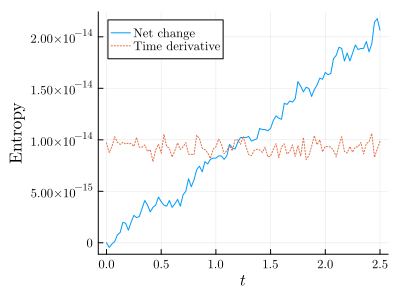

In [155]:
entropy_analysis = EntropyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
entropy_results = analyze(entropy_analysis, load_time_steps(results_path))
entropy = plot(entropy_results, ylabel="Entropy", size=(400,300), fmt=:png) 

We can now visualize the density field as a `.vtu` file, for example, in ParaView.

In [156]:
for i in eachindex(sol.u)
    postprocess_vtk(spatial_discretization, string(results_path,
        "solution_",i,".vtu"), sol.u[i], variable_name="Density")
end

In [157]:
maximum(spatial_discretization.geometric_factors.Λ_q[:,1,1,1]) - minimum(spatial_discretization.geometric_factors.Λ_q[:,1,1,1])

0.07288499288108677